In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

In [ ]:
import os
from random import shuffle
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_files = glob('/content/drive/My Drive/cats_VS_dogs/train/train/*.jpg')
test_files = glob('/content/drive/My Drive/cats_VS_dogs/test/test/*.jpg')


In [ ]:
#image preprocessing
IMG_SIZE = (224, 224)

def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)
batch_size = 16
# generator function for train data load from disk
def fit_generator(files, batch_size=batch_size):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            # labels creation based on fig. name
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# generator function for test data load from disk
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

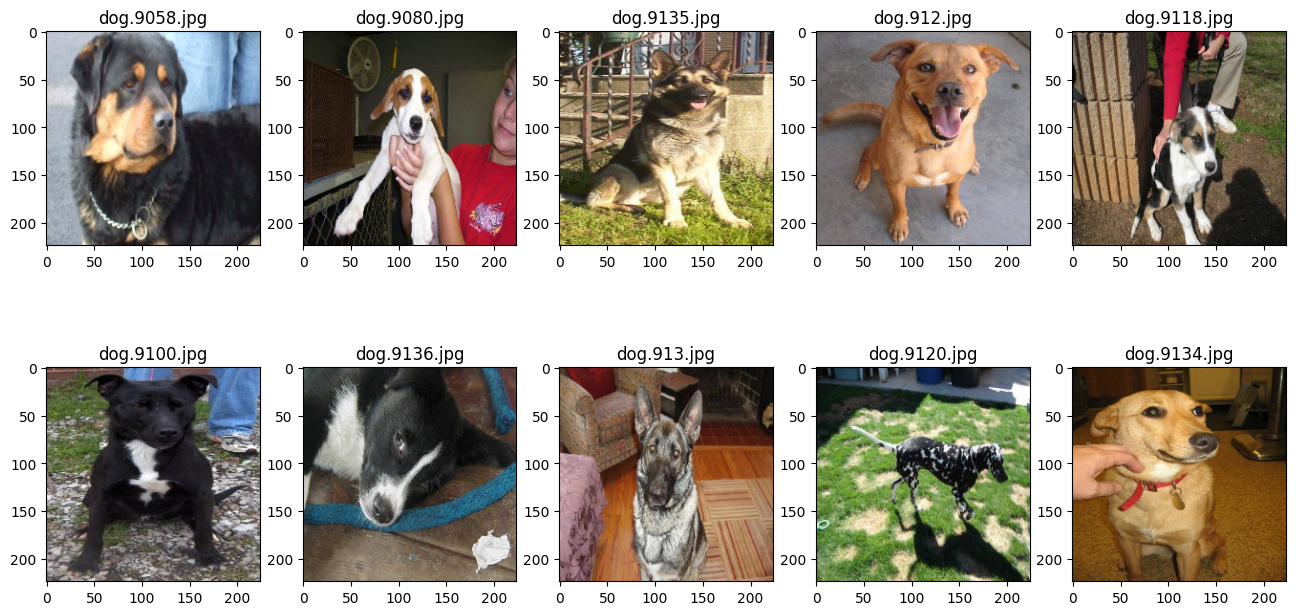

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [ ]:
# loading the pretrained model
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# model summary
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# fixation of pretrained model weights
for layer in base_model.layers:
    layer.trainable = False
x = base_model.layers[-5].output

#fixation of the randomness
import random
seed = 40
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
conv_initializer = tf.keras.initializers.GlorotUniform(seed=seed)
dense_initializer = tf.keras.initializers.GlorotUniform(seed=seed)

# adding layers:
# trainable convolutional, pooling, flatten and a trainable fully-coupled
x = tf.keras.layers.Conv2D(512, (5, 5), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,
                          activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

In [ ]:
#model compilation
from tensorflow.keras.optimizers import Adam

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                                initial_learning_rate=0.0004,
                                decay_steps=100000,
                                decay_rate=0.98,
                                staircase=True)


model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_callback = ModelCheckpoint(
#     'model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     save_weights_only=False,
#     verbose=1
# )

In [ ]:
# number of validation set
val_samples = 100

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

# learning
history = model.fit(train_data,
          # number of calls of the generator function per epoch
          steps_per_epoch=16,
          epochs=12,
          validation_data=validation_data,
          #callbacks = [checkpoint_callback]
          )

Epoch 1/12
16/16 [==============================] - 224s 14s/step - loss: 0.2951 - accuracy: 0.8984 - val_loss: 0.1955 - val_accuracy: 0.8900
Epoch 2/12
16/16 [==============================] - 223s 14s/step - loss: 0.2139 - accuracy: 0.9219 - val_loss: 0.1685 - val_accuracy: 0.9200
Epoch 3/12
16/16 [==============================] - 225s 14s/step - loss: 0.1914 - accuracy: 0.9453 - val_loss: 0.3225 - val_accuracy: 0.8700
Epoch 4/12
16/16 [==============================] - 223s 14s/step - loss: 0.4186 - accuracy: 0.8711 - val_loss: 0.3428 - val_accuracy: 0.8500
Epoch 5/12
16/16 [==============================] - 224s 14s/step - loss: 0.2301 - accuracy: 0.8945 - val_loss: 0.2263 - val_accuracy: 0.9100
Epoch 6/12
16/16 [==============================] - 223s 14s/step - loss: 0.2080 - accuracy: 0.9180 - val_loss: 0.1970 - val_accuracy: 0.9100
Epoch 7/12
16/16 [==============================] - 224s 14s/step - loss: 0.1493 - accuracy: 0.9297 - val_loss: 0.1299 - val_accuracy: 0.9200
Epoch 

In [ ]:
model.save('cats-dogs-vgg16.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12520/12520 [==============================] - 6397s 511ms/step


In [ ]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path), score))


<ipython-input-16-3ee77cdef0f4>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path), score))


In [ ]:
test_pred

array([[1.0000000e+00],
       [9.0460575e-20],
       [1.5214142e-01],
       ...,
       [4.5616561e-01],
       [1.0000000e+00],
       [9.6903414e-01]], dtype=float32)

In [ ]:
import pandas as pd
df_res = pd.read_csv('submit.txt')
df_res

id     label
<re.Match object; span=(47  55)    match='9092.jpg'>  1.000000
                            55)    match='9103.jpg'>  0.000000
                            53)      match='91.jpg'>  0.152141
                            55)    match='9102.jpg'>  0.589378
                            55)    match='9104.jpg'>  0.955864
...                                              ...       ...
                            56)   match='10428.jpg'>  0.795965
                            56)   match='10444.jpg'>  0.999974
                            56)   match='10426.jpg'>  0.456166
                            56)   match='10448.jpg'>  1.000000
                            56)   match='10421.jpg'>  0.969034

[12520 rows x 2 columns]

In [ ]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12520 entries, ('<re.Match object; span=(47', ' 55)') to ('<re.Match object; span=(47', ' 56)')
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      12500 non-null  object 
 1   label   12500 non-null  float64
dtypes: float64(1), object(1)
memory usage: 220.9+ KB


In [ ]:
def extract_integers(s):
    match = re.search(r"match='(\d+)\.jpg'", s)
    if match:
        return match.group(1)
    return None

# Apply the function to the 'id' column
df_res['id'] = df_res['id'].astype(str)
df_res['id'] = df_res['id'].apply(extract_integers)
df_res = df_res.dropna()
df_res['id'] = df_res['id'].astype(int)

<ipython-input-20-5d2197fa6605>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['id'] = df_res['id'].astype(int)


In [ ]:
df_res.reindex(columns = ['id', 'label'])
df_res.drop_duplicates()
df_res_sorted = df_res.sort_values(by = 'id')
df_res_sorted

id     label
<re.Match object; span=(47  52)      1  1.000000
                            52)      2  1.000000
                            52)      3  1.000000
                            52)      4  1.000000
                            52)      5  0.000035
...                                ...       ...
                            56)  12496  0.000000
                            56)  12497  0.000000
                            56)  12498  1.000000
                            56)  12499  1.000000
                            56)  12500  0.410755

[12500 rows x 2 columns]

In [ ]:
from google.colab import files
df_res_sorted.to_csv('predictions_cats_VS_dogs.csv', index=False)
files.download('predictions_cats_VS_dogs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-24-aee2140b7996>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


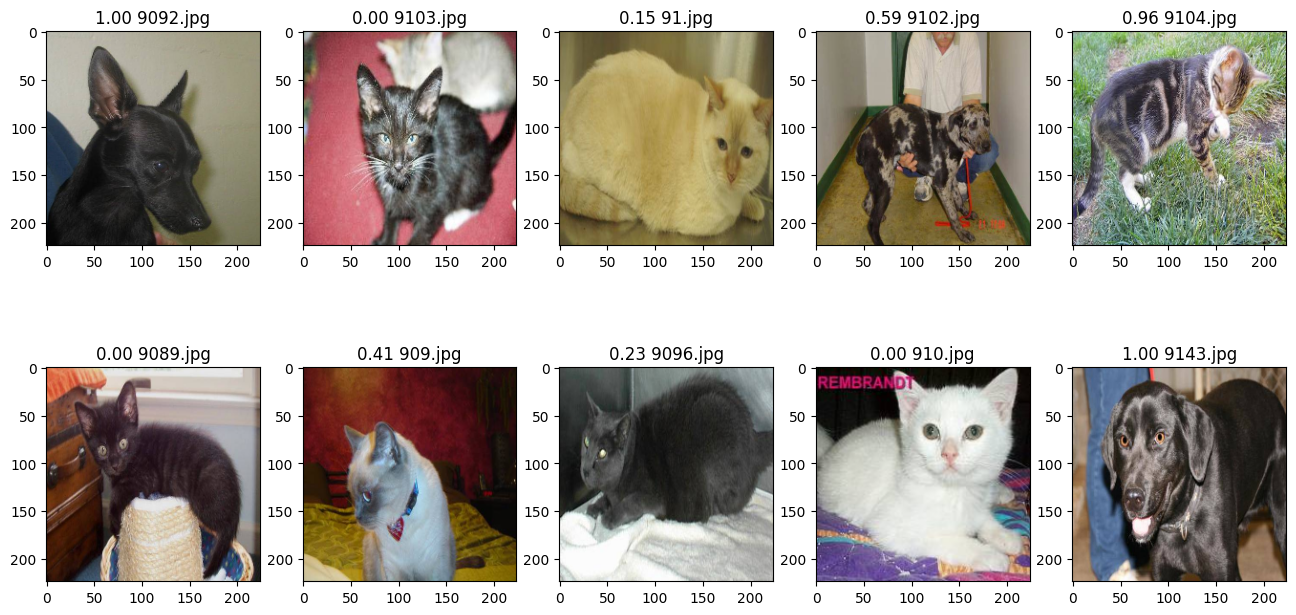

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)